<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch

### 1. Нахождение сложной производной

Найдите производную по x от функции 
$$\sin\left(\tan(x)\frac{x^2}{y} + \ln(e^{-x^2 + 3}+x^3y)\right)\tan(x^2e^{x^9})$$

При этом надо пользоваться встроенным в PyTorch autograd. Численное вычисление производной может не дать нужный результат.

In [2]:
def find_x_derivative(x, y):
    # YOUR CODE HERE
    x = torch.tensor([x], dtype=float, requires_grad=True)
    y = torch.tensor([y], dtype=float, requires_grad=True)
    function = torch.sin(torch.tan(x)*x**2/y + torch.log(torch.exp((-x**2)+3)
                  + (x**3)*y))*torch.tan((x**2)*torch.exp(x**9))
    function.backward()
    gradient = x.grad
    
    return gradient# YOUR CODE HERE

print(find_x_derivative(1,21))

tensor([-9.0207], dtype=torch.float64)


In [3]:
find_x_derivative(1,21)

tensor([-9.0207], dtype=torch.float64)

In [4]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
y = x + 2
print(y)
print(y.grad_fn)
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [5]:
out.backward()

In [6]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


# 2. Нахождение косинусной близости

Вам даны две матрицы A и B. Необходимо посчитать косинусную близость между строчками матрицы A и столбцами матрицы B. Ответ - матрица чисел, где номер строки - номер строки из матрицы А, а номер столбца - номер столбца из В, от которых бралась косинусная близость.

Напомним, что косинусная близость двух векторов - косинус угла между ними. В n-мерном пространстве косинус угла между веткорами удобнее всего через скалярное произведение:
$$\cos(angle(x, y)) = \frac{x \cdot y}{\left\|x\right\| \left\|y\right\|}$$

(Наша операция очень похожа на умножение матриц)

In [7]:
A = torch.FloatTensor([[1, -47, 25, -3], 
                       [10, 17, -15, 22],
                       [-3, -7, 26, 36],
                       [12, -27, -42, 0]])
B = torch.FloatTensor([[-50, -13, 1, 10, 1242], 
                       [21, 48, -13, -14, -20],
                       [20, 15, 11, 43, 11],
                       [11, 103, 147, 27, -8]])

In [8]:
def get_cos_sim(A, B):
    """
        A, B - torch float tensors
    """
    cos_ang = (A/torch.norm(A, dim = 1, keepdim = True)) @ (B/torch.norm(B, dim = 0, keepdim = True))
    # YOUR CODE HERE
    
    return cos_ang# YOUR CODE HERE

torch.mean(get_cos_sim(A,B))

tensor(0.1498)

# 3. Линейная регрессия

Раньше мы самостоятельно считали производные, чтобы находить веса линейной регрессии с помощью градиентного спуска. Теперь нам нужно использовать для этого PyTorch и его autograd. 

**Важно**: на самом деле .backward не обновляет содержимое матриц с производными (some_tensor.grad), а прибавляет к ним только что посчитаные значения проивзодных. Это значит, что вызвав .backward дважды, вы получите удвоенную производную. Так как мы обновляем веса в цикле и много раз вызываем .backward, то очень быстро мы получим мусор в some_tensor.grad, если не будем его каждый раз обнулять. Таким образом, в конц итериации после использования производных обнулите значения в матрице производных для всех нужных Вам переменных. Делается это вот так 
> some\_tensor.grad.data.zero_()

In [16]:
class LinearRegression:
    def get_loss(self, preds, y):
        """
            @param preds: предсказания модели
            @param y: истиные значения
            @return mse: значение MSE на переданных данных
        """
        # возьмите средний квадрат ошибки по всем выходным переменным
        # то есть сумму квадратов ошибки надо поделить на количество_элементов * количество_таргетов
        diff = preds - y
        return torch.sum(diff * diff) / diff.numel() #YOUR_CODE
    
    def init_weights(self, input_size, output_size):
        """
            Инициализирует параметры модели
            W - матрица размерности (input_size, output_size)
            инициализируется рандомными числами из
            uniform распределения (torch.rand())
            b - вектор размерности (1, output_size)
            инициализируется нулями
        """
        torch.manual_seed(0) #необходимо для воспроизводимости результатов
        self.W = torch.rand(input_size, output_size,  requires_grad=True)
        self.b = torch.zeros(1, output_size, requires_grad=True)

    def fit(self, X, y, num_epochs=1000, lr=0.001):
        """
            Обучение модели линейной регрессии методом градиентного спуска
            @param X: размерности (num_samples, input_shape)
            @param y: размерности (num_samples, output_shape)
            @param num_epochs: количество итераций градиентного спуска
            @param lr: шаг градиентного спуска
            @return metrics: вектор значений MSE на каждом шаге градиентного
            спуска.
        """
        self.init_weights(X.shape[1], y.shape[1])
        metrics = []
        for _ in range(num_epochs):
            preds = self.predict(X)
            # сделайте вычисления градиентов c помощью Pytorch и обновите веса
            # осторожнее, оберните вычитание градиента в 
#                 with torch.no_grad():
#                     #some code
            # иначе во время прибавления градиента к переменной создастся очень много нод в дереве операций
            # и ваши модели в будущем будут падать от нехватки памяти
            loss = self.get_loss(preds, y)
            loss.backward()
            
            with torch.no_grad():
                self.W -= self.W.grad * 0.001
                self.b -= self.b.grad * lr
                self.W.grad.zero_()
                self.b.grad.zero_()#YOUR_CODE
            #YOUR_CODE
            #YOUR_CODE
            #YOUR_CODE
            metrics.append(self.get_loss(preds, y).data)
        return metrics

    def predict(self, X):
        """
            Думаю, тут все понятно. Сделайте свои предсказания :)
        """
        return X @ self.W + self.b#YOUR_CODE

1. Сгенерируйте данные с помощью make_regression с параметрами n_targets=3, n_features=2, noise=10, random_state=42. 
2. Обучите модель линейной регрессии, оставив в fit параметры num_epochs и lr по умолчанию (обратите внимание, что перед обучением нужно привести данные к типу, использующимся в torch) 
2. Посчитайте среднее значение метрики MSE по всем итерациям цикла в fit (массив из значений MSE на каждой итерации возвращается из метода fit). Ответом, который необходимо сдать в систему, будет число, округленное до 3х знаков после запятой.

In [17]:
X, Y = datasets.make_regression(n_targets=3, n_features=2, noise=10, random_state=42) # YOUR CODE HERE
X = torch.from_numpy(X).float() # YOUR CODE HERE
Y = torch.from_numpy(Y).float() # YOUR CODE HERE
model = LinearRegression()
mse = model.fit(X, Y)

In [18]:
print(np.mean(mse))

4256.561


Здесь предлагаем протестировать метод predict удобным вам образом.

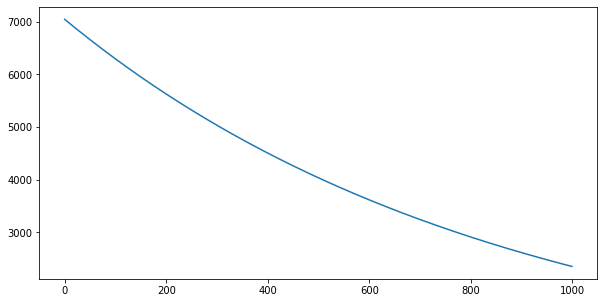

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(mse)
plt.show()

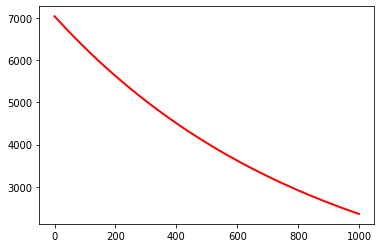

In [31]:
plt.plot(mse, color='red', linewidth=2)
plt.show()

In [27]:
mse

[tensor(7046.5273),
 tensor(7038.5732),
 tensor(7030.6309),
 tensor(7022.6958),
 tensor(7014.7715),
 tensor(7006.8535),
 tensor(6998.9482),
 tensor(6991.0493),
 tensor(6983.1611),
 tensor(6975.2827),
 tensor(6967.4126),
 tensor(6959.5518),
 tensor(6951.7021),
 tensor(6943.8594),
 tensor(6936.0269),
 tensor(6928.2031),
 tensor(6920.3872),
 tensor(6912.5840),
 tensor(6904.7871),
 tensor(6897.0015),
 tensor(6889.2231),
 tensor(6881.4561),
 tensor(6873.6963),
 tensor(6865.9453),
 tensor(6858.2051),
 tensor(6850.4712),
 tensor(6842.7515),
 tensor(6835.0361),
 tensor(6827.3325),
 tensor(6819.6357),
 tensor(6811.9487),
 tensor(6804.2715),
 tensor(6796.6040),
 tensor(6788.9443),
 tensor(6781.2939),
 tensor(6773.6519),
 tensor(6766.0215),
 tensor(6758.3965),
 tensor(6750.7827),
 tensor(6743.1768),
 tensor(6735.5796),
 tensor(6727.9917),
 tensor(6720.4146),
 tensor(6712.8442),
 tensor(6705.2837),
 tensor(6697.7314),
 tensor(6690.1880),
 tensor(6682.6548),
 tensor(6675.1279),
 tensor(6667.6128),
